In [111]:
import os
import keras
import sys
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import Normalizer
sys.path.append('C:/Users/Kaz Mahbub/ppcs2-project/imports')

from parse_fasta import *
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
def plot_bar(x, y, z, size1, size2, title, xlabel, ylabel, save_to=None, fmt='png'):
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.8
    y_pos = np.arange(len(x))
    l1 = 'Before: ' + str(size1)
    l2 = 'After: ' + str(size2)
    rects1 = plt.bar(y_pos, z, bar_width, alpha = opacity, color = 'r', label = l1)
    rects2 = plt.bar(y_pos+bar_width, y, bar_width, alpha = opacity, color = 'b', label = l2)
    
    #plt.bar(x, y, facecolor='b', alpha=0.5, width=0.8)
    
    plt.xticks(y_pos + bar_width, x, rotation = '65')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.title(title.format(save_to))
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Attach a text label above each bar displaying its height
    
    def autolabel(rects, gap,c):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height - gap,
                    str(int(height)),
                    ha='center', va='bottom', fontsize=7, rotation = '65', color=c)
    
    autolabel(rects1, -0.2, 'red')
    autolabel(rects2, -0.2, 'blue')
    plt.tight_layout()
    title = title + ".png"
    plt.savefig(title.format(save_to), format='png', dpi=1000)
    plt.show()

# Pre-process

In [113]:

# Load data
dataset_url = osp.join('..', 'dataset', 'subloc', 'eukaryota', 'subloc_k3_s5_eukaryota.1682.fa_1516057206692442.csv')
df = pd.read_csv(dataset_url, sep=',')
print(df.shape)

(1673, 8002)


In [114]:
# unique labels
labels = df.label.unique()
#print(len(labels), labels)

In [115]:
# transform labels to numerical values
y = df['label'].values
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
freq1 = df['label'].value_counts()
size1 = df.shape[0]
print(size1)
#print(freq1)
d1 = freq1.to_dict()
#print(d1)

1673


In [116]:
# remove datapoints belonging to classes with frequency less than threshold
ths_cls = 10
_, counts = np.unique(y, return_counts=True)
mask = np.isin(y, np.where(counts >= ths_cls)[0])
df = df[mask]
print('New data shape: {}'.format(df.shape))

New data shape: (1654, 8002)


In [117]:
# remove datapoints where kmer frequency sum is less or equal to threshold
ths_kmer = 0
mask = np.sum(df.iloc[:, 2:].values, axis=1) > ths_kmer
df = df[mask]
print('New data shape: {}'.format(df.shape))

size2 = df.shape[0]
print(size2)

New data shape: (1511, 8002)
1511


In [118]:
X = df.iloc[:, 2:].values
num_classes = len(np.unique(y))
X.shape, y.shape, num_classes
freq2 = df['label'].value_counts()
d2 = freq2.to_dict()
d3 = dict()
z_val = []
# put the zero values (i.e. where the frequency is zero) in d3 and put the nonzero values in z_val
for key,value in d1.items():
    z_val.append(value)
    if key not in d2:
        d3[key] = 0


<b>Plotting</b>

['secreted', 'nucleus', 'cytoplasm', 'mitochondria', 'chloroplast', 'memmitochondria', 'memer', 'cellmembrane', 'memgolgi', 'plastid', 'memchloroplast', 'memvacuole', 'er', 'peroxisome', 'memnucleus', 'golgi', 'vacuole', 'memperoxisome']
[503, 305, 211, 136, 122, 75, 61, 39, 16, 14, 10, 10, 9, 0, 0, 0, 0, 0]


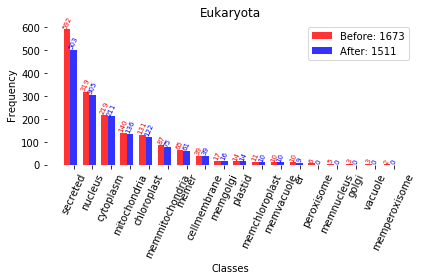

In [119]:
merge = {**d2, **d3}
x_val, y_val = [], []
for key, value in merge.items():
    x_val.append(key)
    y_val.append(value)
print(x_val)
print(y_val)
plot_bar(x_val, y_val, z_val, size1, size2, 'Eukaryota', 'Classes', 'Freq')